In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sys import exit
from scipy import stats
import pvalues
import visualize_data

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn.utils import resample

plt.close('all')

/Users/Bram/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# specify parameters (genre = music genre, year_max = end point on plots, test_year = 'test year' to vizualize data set to check for e.g. normality)
genre = 'house'
year_max = '2016'
test_year = 2014

In [4]:
# specify upper and lower band of confidence interval in model evaluation
conf_band = [2.5,97.5]

In [5]:
####################################
# FUNCTIONS
####################################

def median_filtered(data_nc, threshold = 10):
    """
    Function imports data with potential outliers and 'cleans' it using a median filtering approach
    """
    difference = np.abs(data_nc - np.median(data_nc))
    median_difference = np.median(difference)
    s = 0 if median_difference == 0 else difference / float(median_difference)
    mask = s > threshold
    data_nc[mask] = np.median(data_nc)
    return data_nc
    
def PolyRegression(degree=1):
    """
    This functions makes a pipeline: linear regression together with a 'polynomial preprocessor'
    """
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(fit_intercept=True,normalize=True))

from sklearn.grid_search import GridSearchCV

def RegressionTask(X,y):
    """
    Function performing regression on X,y. Finds correct hyperparameters by tuning + evaluation using a grid search and 10-fold cross validation
    """
    param_grid = {'polynomialfeatures__degree': np.arange(10)}

    grid = GridSearchCV(PolyRegression(), param_grid, cv=10)
    grid.fit(X, y)
    print grid.best_params_
    model = grid.best_estimator_
    return model

def Bootstrap(X,y,X_test,model):
    """
    function performing model fits ntimes to test accuracy error. i.e., get the confidence interval on our performance estimate (r2 score)
    """
    ntimes = 1000
    stat = []
    for i in range(0,ntimes):
        
        index = np.random.choice(range(0, len(y)), len(y))
        X_rs = X[index]
        y_rs = y.values[index]        
        y_test_rs = model.fit(X_rs, y_rs).predict(X_test)
        stat.append(r2_score(y,y_test_rs))
    
    stat_array = np.asarray(stat)
    return stat_array

/Users/Bram/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


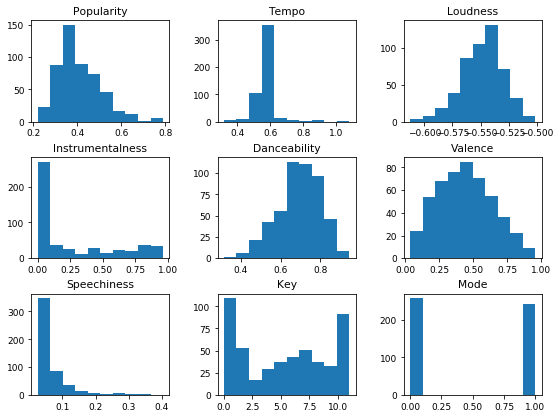

In [6]:
####################################
# LOAD AND WRANGLE DATA
####################################

# load in data 
df = pd.read_pickle('data/'+genre+'_'+year_max)
df_features = pd.read_pickle('data/'+genre+'_features_'+year_max)

# normalize loudness (only column not normalized yet)
df_features['loudness_norm'] = (df_features['loudness'] - 60) / 120

# get statistics for decades
df['release_year'] = df['release_year'].astype(int)
df_80s = df[(df['release_year'] >= 1980) & (df['release_year'] < 1990)]
df_90s = df[(df['release_year'] >= 1990) & (df['release_year'] < 2000)]
df_00s = df[(df['release_year'] >= 2000) & (df['release_year'] < 2010)]
df_10s = df[(df['release_year'] >= 2010) & (df['release_year'] < 2020)]

df_features_80s = df_features[(df['release_year'] >= 1980) & (df['release_year'] < 1990)]
df_features_90s = df_features[(df['release_year'] >= 1990) & (df['release_year'] < 2000)]
df_features_00s = df_features[(df['release_year'] >= 2000) & (df['release_year'] < 2010)]
df_features_10s = df_features[(df['release_year'] >= 2010) & (df['release_year'] < 2020)]

# vizualize data for a given year (in another file)
a = df[df['release_year'].astype(int) == test_year]
b = df_features[df['release_year'].astype(int) == test_year]
visualize_data.vis_data(a,b,genre)

plt.show()

In [7]:
# initiate array
res = []

p1 = 25
p2 = 75

# parse objects to get 50th percentile (for regression) and 25th and 75 percentiles (for plotting).
for i in range(1980,np.int_(year_max)+1):
    # limit each year to 100 songs, so that each bin has roughly same statistics
    a = df[df['release_year'].astype(int) == i][0:100]
    b = df_features[df['release_year'].astype(int) == i][0:100]
    
    # if there is no data for a year skip it
    if len(a) == 0:
        continue 
    
    # parse objects. popularity is normalized to 0 - 1.
    popu = np.median(a['popularity']/100.)
    temp = np.median(b['tempo_norm'])
    loud = np.median(b['loudness_norm'])
    dance = np.median(b['danceability'])
    inst = np.median(b['instrumentalness'])
    val = np.median(b['valence'])
    
    popu_25 = np.percentile(a['popularity']/100.,p1)
    temp_25 = np.percentile(b['tempo_norm'],p1)
    loud_25 = np.percentile(b['loudness_norm'],p1)
    dance_25 = np.percentile(b['danceability'],p1)
    inst_25 = np.percentile(b['instrumentalness'],p1)
    val_25 = np.percentile(b['valence'],p1)
    
    popu_75 = np.percentile(a['popularity']/100.,p2)
    temp_75 = np.percentile(b['tempo_norm'],p2)
    loud_75 = np.percentile(b['loudness_norm'],p2)
    dance_75 = np.percentile(b['danceability'],p2)
    inst_75 = np.percentile(b['instrumentalness'],p2)
    val_75 = np.percentile(b['valence'],p2)
    
    res.append({'popu':popu, 'temp':temp, 'loud':loud, 'dance':dance, 'inst':inst, 'val':val, 'popu_25':popu_25, 'temp_25':temp_25, 'loud_25':loud_25, 'dance_25':dance_25, 'inst_25':inst_25, 'val_25':val_25,  'popu_75':popu_75, 'temp_75':temp_75, 'loud_75':loud_75, 'dance_75':dance_75, 'inst_75':inst_75, 'val_75':val_75})
        
# save to dataframe
result = pd.DataFrame(res)

In [8]:
####################################
# POLYNOMIAL REGRESSION + PLOTTING
####################################

# create X-axis vector (timeline)
X = np.arange(np.int_(year_max)+1 - len(result), np.int_(year_max)+1,1)
X = X.reshape(len(X),1)

# create another X-vector to test the fitted model
X_test = np.linspace(df['release_year'].min(), 2017, len(X))[:, None]

In [9]:
# for every subplot, I populate it with the original data (including errorbars representing 25 to 75 data)
# the regression is then performed on the median of the data for every year
# obvious outliers are cleaned out using a median filter approach; threshold is set high to incorporate as much 'original' data as possible.
features = ['popu','temp','loud','dance','inst','val']
features_label = ['Popularity','Tempo','Loudness','Danceability','Instrumentalness','Valence']

fig = plt.figure(figsize=(7,8))
font = {'size':9}
plt.rc('font', **font)

plt.subplots_adjust(left=0.2, bottom=0.2, right=0.875, top=0.85, wspace=0.35, hspace=0.35)
alpha = 0.2

{'polynomialfeatures__degree': 2}
{'polynomialfeatures__degree': 3}
{'polynomialfeatures__degree': 1}
{'polynomialfeatures__degree': 4}
{'polynomialfeatures__degree': 3}
{'polynomialfeatures__degree': 5}


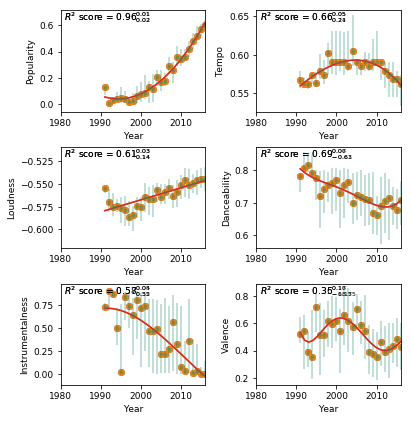

In [13]:
test_values = X_test
for i in range(0, len(features)):
    # open plot, plot the relevant data, and label axes.
    ax = plt.subplot(3, 2, i+1)
    plt.scatter(X,result[features[i]])
    plt.errorbar(X,result[features[i]],yerr=(result[features[i]]-result[features[i]+'_25'],result[features[i]+'_75']-result[features[i]]),fmt='.',alpha=alpha)
    plt.xlabel('Year')
    plt.xlim([1980,2016])
    plt.ylabel(features_label[i])

    # do the outlier detection, perform regression (+ model evaluation), and do a bootstrap to get confidence interval on R2 score.
    y = median_filtered(result[features[i]].to_frame())
    model = RegressionTask(X, y)
    y_test = model.fit(X, y).predict(X_test)
    stat = Bootstrap(X,y,X_test,model)
    plt.text(0.025, 0.9,r"$R^2$ score = ${:.2f}_{{{:.2f}}}^{{{:.2f}}}$".format(np.median(stat),np.median(stat)-np.abs(np.percentile(stat,conf_band[0])),np.percentile(stat,conf_band[1])-np.median(stat)), transform=ax.transAxes)
    plt.plot(X_test.ravel(), y_test)
    
    # append results to a 2d-array (to be converted to dataframe)
    test_values = np.hstack([test_values,y_test])
    
# show and save plot!
plt.show()
plt.savefig('output/'+genre+'_evolution.pdf', dpi=150, bbox_inches='tight', pad_inches=0.2)

In [11]:
# option to save regression models which can then be plotted in combine_plots
df = pd.DataFrame(test_values,
                  columns=['X','popu','temp','loud','dance','inst','val'])
df.to_pickle('data/'+genre+'_models')

In [12]:
# has the music evolved significantly?
p9010 = pd.Series(pvalues.calc_pvalues(df_features_90s,df_features_10s),index=['Tempo', 'Loudness', 'Danceability', 'Valence'],name='1990s vs 2010s')
p0010 = pd.Series(pvalues.calc_pvalues(df_features_00s,df_features_10s),index=['Tempo', 'Loudness', 'Danceability', 'Valence'],name='2000s vs 2010s')

pvalues = pd.concat([p9010, p0010], axis=1)
pvalues

,1990s vs 2010s,2000s vs 2010s
Tempo,7.395021e-05,1.344878e-51
Loudness,9.496981e-117,8.148901e-234
Danceability,1.051524e-09,5.789747e-20
Valence,1.546506e-26,1.144226e-30
